## Imports

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import LSTM

# from tensorflow.keras.models import Sequential

from tensorflow.keras.losses import MeanSquaredError
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from keras.preprocessing.sequence import TimeseriesGenerator

#import np.array as array



## Load Datasets
##### As Pandas DataFrame objects

In [ ]:
# Load Dataset
#import csv as a pandas dataframe
training_path = "D:\OneDrive\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\Training_Port1.csv"
test_path = "D:\OneDrive\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\Test_Stbd1.csv"
df_train=pd.read_csv(training_path)
df_test=pd.read_csv(test_path)

In [5]:
pd.get_option("display.max_columns")

In [4]:
pd.set_option("display.max_columns", None)

In [ ]:
df_train.shape


In [ ]:
df_train.tail(5)


In [6]:
df_test.head()

Ping#  Sample#  Port/Stbd  SampleTimeDelay      I1      Q1     I2      Q2  \
0      7        5          1         0.000061  0.0000  0.0000  0.000  0.0000   
1      7       19          1         0.000276  0.0000  0.0000  0.000  0.0625   
2      7       20          1         0.000292  0.0625  0.0000  0.125  0.0000   
3      7       21          1         0.000307  0.0000 -0.0625  0.000 -0.1875   
4      7       22          1         0.000323 -0.0625  0.0000 -0.250  0.0625   

       I3     Q3      I4      Q4      I5      Q5      I6      Q6      I7  \
0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1  0.0000  0.125  0.0000  0.1250  0.0000  0.0625  0.0000  0.0000  0.0000   
2  0.1875  0.000  0.1875 -0.0625  0.1250  0.0000  0.0000  0.0000  0.0000   
3 -0.0625 -0.250 -0.1875 -0.2500 -0.0625 -0.1250  0.0000 -0.0625  0.0625   
4 -0.3125  0.125 -0.2500  0.3125 -0.1875  0.1250 -0.0625  0.0000 -0.0625   

       Q7      I8      Q8      I9      Q9     I10     Q10      Roll        C  \
0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.488892  1492.04   
1  0.0000 -0.0625  0.0000  0.0000  0.0000  0.0000  0.0000  0.488892  1492.04   
2  0.0625  0.0000  0.0625  0.0000  0.0000  0.0000  0.0000  0.488892  1492.04   
3 -0.0625  0.1250  0.0000  0.0625  0.0000  0.0000 -0.0625  0.488892  1492.04   
4 -0.0625  0.0000 -0.1875  0.0000 -0.0625 -0.0625  0.0000  0.488892  1492.04   

         DOA      TWTT  Amplitude  AngleUncertainty   SampleRate     Range  
0 -55.809999  0.000261          0                 0  65108.40625  0.194788  
1 -59.234999  0.000276          0               126  65108.40625  0.206246  
2 -59.234999  0.000292          0                83  65108.40625  0.217704  
3 -59.234999  0.000307          0                69  65108.40625  0.229162  
4 -58.524999  0.000323          0               120  65108.40625  0.240621

In [ ]:
# Model Configuration
#addition_metrics = ['accuracy']
#batch_size = 128
#embedding_output_dims = 15
#loss_function = MeanSquaredError()
#max_sequence_length = 300
#num_distinct_words = 5000
#number_of_epochs = 5
#optimizer = Adam()
#validation_split = 0.20
#verbosity_mode = 1

# Function Declarations

In [7]:
# Function to get a given ping #'s data and put it into corresponding locations.
def GetPingNumber(pingnum, source):
    if (source == 'train'):
        df = df_train[df_train['Ping#']==pingnum]
    if (source == 'test'):
        df = df_test[df_test['Ping#']==pingnum]
        
    return df


In [8]:
# Function to get the important columns out of a dataframe object..
def GetColumns(in_df_obj, ColumnTypes):
    if (ColumnTypes == 'InputData'):
        df1 = in_df_obj.iloc[:,3:24]    # SampleTimeDelay through (including) Roll.
        df2 = in_df_obj.iloc[:,28]      # 28 is Amplitude values
        df = pd.concat([df1, df2], axis=1)
        #df1 = in_df_obj[in_df_obj.iloc[:,3:24]]     # 3:24 contain the SampleTimeDelay and IQ vals.
        #df2 = in_df_obj[in_df_obj.iloc[:,29]]       # 29 is the Amplitude value
        #df = df1.append(df2)
        
    if (ColumnTypes == 'TrueData'):
        df = in_df_obj.iloc[:,26]                   # 26 is the DOA values
        #df = in_df_obj[in_df_obj.iloc[27]]
        #colRange1 = 

    if (ColumnTypes == 'FirstFew'): # this returns only columns 'Ping#', 'Sample#', 'Port/Stbd', and 'SampleTimeDelay'. (To Scale between 0 and 1)
        df = in_df_obj.iloc[:,0:4]

    if (ColumnTypes == 'IQandROLL'): #This only returns the I & Q Data columns and the Roll data column (To Scale between -1 and 1)
        df = in_df_obj.iloc[:, 4:25] 

    if (ColumnTypes == 'C'):        # this returns only the 'C' column (To Scale between 0 and 1)
        df = in_df_obj.iloc[:, 25]

    if (ColumnTypes == 'DOA'):      # this returns only the 'DOA' column (To Scale between -1 and 1)
        df = in_df_obj.iloc[:, 26]

    if (ColumnTypes == 'LastFew'):  # this returns only the 'TWTT', 'Amplitude', 'AngleUncertainty', 'SampleRate', and 'Range' columns. (To Scale between 0 and 1)
        df = in_df_obj.iloc[:, 27:32]

    return df


In [9]:
def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame

In [10]:
scaler = MinMaxScaler()
scaler_neg1_1 = MinMaxScaler((-1,1))

In [ ]:
df_train.iat[0,0]


In [ ]:
dfPing7 = GetPingNumber(7, 'train')
dfPing7

In [ ]:
df_train_firstFewColumns = df_train

In [11]:
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)

df_train_scaled['Ping#'] = df_train['Ping#']

df_train_scaled['SampleRate'] = df_train['SampleRate']

df_train_scaled['Range'] = df_train['Range']

df_train_scaled['C'] = df_train['C']

df_train_scaled['Port/Stbd'] = df_train['Port/Stbd']


#df_train_scaled['Sample#'] = df_train['Sample#']



df_test_scaled = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)
df_test_scaled['Ping#'] = df_test['Ping#']
df_test_scaled['SampleRate'] = df_test['SampleRate']
df_test_scaled['Range'] = df_test['Range']
df_test_scaled['C'] = df_test['C']
df_test_scaled['Port/Stbd'] = df_test['Port/Stbd']

#df_train_scaled['Sample#'] = df_train['Sample#']


In [12]:
C_Array = pd.DataFrame(GetColumns(df_train, 'C'))

#C_Array.reshape(-1, 1)

C_Array

C
0        1492.040
1        1492.040
2        1492.040
3        1492.040
4        1492.040
...           ...
5504452  1491.949
5504453  1491.949
5504454  1491.949
5504455  1491.949
5504456  1491.949

[5504457 rows x 1 columns]

In [13]:
FirstFewScaled = pd.DataFrame(scaler.fit_transform(GetColumns(df_train, 'FirstFew')), columns=df_train.columns[0:4])

FirstFewScaled['Ping#']=df_train['Ping#']
FirstFewScaled['Sample#']=df_train['Sample#']
FirstFewScaled['Port/Stbd']=df_train['Port/Stbd']
FirstFewScaled.head()

Ping#  Sample#  Port/Stbd  SampleTimeDelay
0      7        5          0         0.000000
1      7        6          0         0.000233
2      7        7          0         0.000466
3      7        8          0         0.000698
4      7        9          0         0.000931

In [14]:
IQandROLL = pd.DataFrame(scaler_neg1_1.fit_transform(GetColumns(df_train, 'IQandROLL')), columns=df_train.columns[4:25])
IQandROLL.head()

I1        Q1        I2        Q2       I3        Q3        I4  \
0  0.126465  0.039453 -0.081946  0.169626 -0.00804  0.072351 -0.072821   
1  0.126465  0.039453 -0.081946  0.169626 -0.00804  0.072351 -0.072821   
2  0.126465  0.039453 -0.081946  0.169626 -0.00804  0.072351 -0.072821   
3  0.126465  0.039453 -0.081946  0.169626 -0.00804  0.072351 -0.072821   
4  0.126465  0.039453 -0.081946  0.169626 -0.00804  0.072351 -0.072821   

         Q4       I5        Q5        I6        Q6        I7        Q7  \
0 -0.014608 -0.02566 -0.024656 -0.049759 -0.005408 -0.052884 -0.020516   
1 -0.014608 -0.02566 -0.024656 -0.049759 -0.005408 -0.052884 -0.020516   
2 -0.014608 -0.02566 -0.024656 -0.049759 -0.005408 -0.052884 -0.020516   
3 -0.014608 -0.02566 -0.024656 -0.049759 -0.005408 -0.052884 -0.020516   
4 -0.014608 -0.02566 -0.024656 -0.049759 -0.005408 -0.052884 -0.020516   

         I8        Q8        I9        Q9       I10       Q10      Roll  
0 -0.067236 -0.119361  0.020121 -0.073706  0.132279 -0.075426  0.147727  
1 -0.067236 -0.119361  0.020121 -0.073706  0.132279 -0.075426  0.147727  
2 -0.067236 -0.119361  0.020121 -0.073706  0.132279 -0.075426  0.147727  
3 -0.067236 -0.119361  0.020121 -0.073706  0.132279 -0.075426  0.147727  
4 -0.067236 -0.119361  0.020121 -0.073706  0.132279 -0.075426  0.147727

In [15]:
C_COLUMN = pd.DataFrame(scaler.fit_transform(pd.DataFrame(GetColumns(df_train, 'C'), columns=[df_train.columns[25]])), columns=[df_train.columns[25]])
C_COLUMN.head()

#

C
0  0.90991
1  0.90991
2  0.90991
3  0.90991
4  0.90991

In [16]:
DOA_COLUMN = pd.DataFrame(scaler_neg1_1.fit_transform(pd.DataFrame(GetColumns(df_train, 'DOA'), columns=[df_train.columns[26]])), columns=[df_train.columns[26]])
DOA_COLUMN.head()

DOA
0  0.011516
1  0.011516
2  0.011516
3  0.011516
4  0.011516

In [17]:
LastFew = pd.DataFrame(scaler.fit_transform(pd.DataFrame(GetColumns(df_train, 'LastFew'), columns=df_train.columns[27:32])), columns=df_train.columns[27:32])
LastFew['TWTT']=df_train['TWTT']
LastFew['AngleUncertainty']=df_train['AngleUncertainty']
LastFew['SampleRate']=df_train['SampleRate']
LastFew['Range']=df_train['Range']
LastFew.head()

TWTT  Amplitude  AngleUncertainty   SampleRate     Range
0  0.000061        0.0                 0  65108.40625  0.045832
1  0.000077        0.0                 0  65108.40625  0.057291
2  0.000092        0.0                 0  65108.40625  0.068749
3  0.000108        0.0                 0  65108.40625  0.080207
4  0.000123        0.0                 0  65108.40625  0.091665

In [19]:
df_train_scaled_properly = pd.concat([FirstFewScaled, IQandROLL, C_COLUMN, DOA_COLUMN, LastFew], axis=1)
df_train_scaled_properly.head()

Ping#  Sample#  Port/Stbd  SampleTimeDelay        I1        Q1        I2  \
0      7        5          0         0.000000  0.126465  0.039453 -0.081946   
1      7        6          0         0.000233  0.126465  0.039453 -0.081946   
2      7        7          0         0.000466  0.126465  0.039453 -0.081946   
3      7        8          0         0.000698  0.126465  0.039453 -0.081946   
4      7        9          0         0.000931  0.126465  0.039453 -0.081946   

         Q2       I3        Q3        I4        Q4       I5        Q5  \
0  0.169626 -0.00804  0.072351 -0.072821 -0.014608 -0.02566 -0.024656   
1  0.169626 -0.00804  0.072351 -0.072821 -0.014608 -0.02566 -0.024656   
2  0.169626 -0.00804  0.072351 -0.072821 -0.014608 -0.02566 -0.024656   
3  0.169626 -0.00804  0.072351 -0.072821 -0.014608 -0.02566 -0.024656   
4  0.169626 -0.00804  0.072351 -0.072821 -0.014608 -0.02566 -0.024656   

         I6        Q6        I7        Q7        I8        Q8        I9  \
0 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361  0.020121   
1 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361  0.020121   
2 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361  0.020121   
3 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361  0.020121   
4 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361  0.020121   

         Q9       I10       Q10      Roll        C       DOA      TWTT  \
0 -0.073706  0.132279 -0.075426  0.147727  0.90991  0.011516  0.000061   
1 -0.073706  0.132279 -0.075426  0.147727  0.90991  0.011516  0.000077   
2 -0.073706  0.132279 -0.075426  0.147727  0.90991  0.011516  0.000092   
3 -0.073706  0.132279 -0.075426  0.147727  0.90991  0.011516  0.000108   
4 -0.073706  0.132279 -0.075426  0.147727  0.90991  0.011516  0.000123   

   Amplitude  AngleUncertainty   SampleRate     Range  
0        0.0                 0  65108.40625  0.045832  
1        0.0                 0  65108.40625  0.057291  
2        0.0                 0  65108.40625  0.068749  
3        0.0                 0  65108.40625  0.080207  
4        0.0                 0  65108.40625  0.091665

In [21]:

#C_Array = GetColumns(df_train, 'C')

#C_Array.reshape(-1, 1)


FirstFewScaled = pd.DataFrame(scaler.fit_transform(GetColumns(df_train, 'FirstFew')), columns=df_train.columns[0:4])

df_train_properlyScaled = pd.concat([pd.DataFrame(scaler.fit_transform(pd.DataFrame(GetColumns(df_train, 'FirstFew'), columns=df_train.columns[0:4])), columns=df_train.columns[0:4]), pd.DataFrame(scaler_neg1_1.fit_transform(pd.DataFrame(GetColumns(df_train, 'IQandROLL'), columns=df_train.columns[4:24])), columns=df_train.columns[4:24]), pd.DataFrame(scaler.fit_transform(pd.DataFrame(GetColumns(df_train, 'C'), columns=[df_train.columns[25]])), columns=[df_train.columns[25]]), pd.DataFrame(scaler_neg1_1.fit_transform(pd.DataFrame(GetColumns(df_train, 'DOA'), columns=[df_train.columns[26]])), columns=[df_train.columns[26]]), pd.DataFrame(scaler.fit_transform(pd.DataFrame(GetColumns(df_train, 'LastFew'), columns=df_train.columns[27:32])), columns=df_train.columns[27:32])], axis=1)

df_train_properlyScaled['Ping#'] = df_train['Ping#']

df_train_properlyScaled['SampleRate'] = df_train['SampleRate']
df_train_properlyScaled['Sample#'] = df_train['Sample#']

#df_train_properlyScaled['Range'] = df_train['Range']

df_train_properlyScaled['Port/Stbd'] = df_train['Port/Stbd']

In [22]:
df_train_properlyScaled

Ping#  Sample#  Port/Stbd  SampleTimeDelay        I1        Q1  \
0            7        5          0         0.000000  0.126465  0.039453   
1            7        6          0         0.000233  0.126465  0.039453   
2            7        7          0         0.000466  0.126465  0.039453   
3            7        8          0         0.000698  0.126465  0.039453   
4            7        9          0         0.000931  0.126465  0.039453   
...        ...      ...        ...              ...       ...       ...   
5504452   1287     4297          0         0.999069  0.121114  0.044620   
5504453   1287     4298          0         0.999302  0.113040  0.045212   
5504454   1287     4299          0         0.999534  0.118403  0.042763   
5504455   1287     4300          0         0.999767  0.133273  0.036062   
5504456   1287     4301          0         1.000000  0.139464  0.034649   

               I2        Q2        I3        Q3        I4        Q4        I5  \
0       -0.081946  0.169626 -0.008040  0.072351 -0.072821 -0.014608 -0.025660   
1       -0.081946  0.169626 -0.008040  0.072351 -0.072821 -0.014608 -0.025660   
2       -0.081946  0.169626 -0.008040  0.072351 -0.072821 -0.014608 -0.025660   
3       -0.081946  0.169626 -0.008040  0.072351 -0.072821 -0.014608 -0.025660   
4       -0.081946  0.169626 -0.008040  0.072351 -0.072821 -0.014608 -0.025660   
...           ...       ...       ...       ...       ...       ...       ...   
5504452 -0.083122  0.178632 -0.002254  0.079035 -0.063930 -0.020709 -0.027349   
5504453 -0.080127  0.186429  0.008223  0.079022 -0.060508 -0.026925 -0.034740   
5504454 -0.078292  0.179990  0.002376  0.074005 -0.069849 -0.025049 -0.038134   
5504455 -0.078637  0.161131 -0.017923  0.066466 -0.081052 -0.008922 -0.020051   
5504456 -0.076849  0.154248 -0.022050  0.060486 -0.084883 -0.002492 -0.010444   

               Q5        I6        Q6        I7        Q7        I8        Q8  \
0       -0.024656 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361   
1       -0.024656 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361   
2       -0.024656 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361   
3       -0.024656 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361   
4       -0.024656 -0.049759 -0.005408 -0.052884 -0.020516 -0.067236 -0.119361   
...           ...       ...       ...       ...       ...       ...       ...   
5504452 -0.039358 -0.061524 -0.009766 -0.058393 -0.013365 -0.058956 -0.116415   
5504453 -0.042661 -0.069515 -0.005851 -0.058193 -0.003906 -0.050520 -0.111983   
5504454 -0.032114 -0.062345  0.000133 -0.052623 -0.006683 -0.056262 -0.114607   
5504455 -0.017183 -0.040501 -0.010461 -0.054019 -0.027732 -0.075068 -0.117509   
5504456 -0.009634 -0.027260 -0.015883 -0.052822 -0.043195 -0.085361 -0.122058   

               I9        Q9       I10       Q10        C       DOA      TWTT  \
0        0.020121 -0.073706  0.132279 -0.075426  0.90991  0.011516  0.000000   
1        0.020121 -0.073706  0.132279 -0.075426  0.90991  0.011516  0.000233   
2        0.020121 -0.073706  0.132279 -0.075426  0.90991  0.011516  0.000466   
3        0.020121 -0.073706  0.132279 -0.075426  0.90991  0.011516  0.000698   
4        0.020121 -0.073706  0.132279 -0.075426  0.90991  0.011516  0.000931   
...           ...       ...       ...       ...      ...       ...       ...   
5504452  0.024596 -0.079996  0.130999 -0.075983  0.09009 -0.337935  0.999069   
5504453  0.031353 -0.088027  0.122531 -0.087641  0.09009 -0.322072  0.999302   
5504454  0.029071 -0.085000  0.121772 -0.085909  0.09009 -0.317891  0.999534   
5504455  0.019956 -0.068154  0.132603 -0.071435  0.09009 -0.321873  0.999767   
5504456  0.008739 -0.056688  0.141113 -0.060410  0.09009 -0.297713  1.000000   

         Amplitude  AngleUncertainty   SampleRate         Range  
0         0.000000          0.000000  65108.40625  6.302802e-08  
1         0.000000          0.000000  65108.40625  2.328361e-04  
2  

In [23]:
df_train_properlyScaled.describe()

Ping#       Sample#  Port/Stbd  SampleTimeDelay            I1  \
count  5.504457e+06  5.504457e+06  5504457.0     5.504457e+06  5.504457e+06   
mean   6.470000e+02  2.153000e+03        0.0     5.000000e-01  1.264778e-01   
std    3.697928e+02  1.240437e+03        0.0     2.887423e-01  4.173832e-02   
min    7.000000e+00  5.000000e+00        0.0     0.000000e+00 -1.000000e+00   
25%    3.270000e+02  1.079000e+03        0.0     2.500000e-01  1.159875e-01   
50%    6.470000e+02  2.153000e+03        0.0     5.000000e-01  1.264651e-01   
75%    9.670000e+02  3.227000e+03        0.0     7.500000e-01  1.369545e-01   
max    1.287000e+03  4.301000e+03        0.0     1.000000e+00  1.000000e+00   

                 Q1            I2            Q2            I3            Q3  \
count  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06   
mean   3.947868e-02 -8.194078e-02  1.696534e-01 -8.030354e-03  7.240320e-02   
std    4.735650e-02  5.484312e-02  4.701740e-02  5.302079e-02  4.711205e-02   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%    2.753108e-02 -9.599523e-02  1.576224e-01 -2.174575e-02  6.013396e-02   
50%    3.945315e-02 -8.194562e-02  1.696262e-01 -8.040446e-03  7.235058e-02   
75%    5.137521e-02 -6.789601e-02  1.816569e-01  5.710544e-03  8.459432e-02   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                 I4            Q4            I5            Q5            I6  \
count  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06   
mean  -7.282897e-02 -1.455575e-02 -2.568082e-02 -2.460683e-02 -4.977289e-02   
std    4.642880e-02  5.031420e-02  5.382881e-02  5.293257e-02  4.906452e-02   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%   -8.487026e-02 -2.766957e-02 -3.969877e-02 -3.841471e-02 -6.237296e-02   
50%   -7.282143e-02 -1.460816e-02 -2.566010e-02 -2.465603e-02 -4.975914e-02   
75%   -6.075939e-02 -1.489459e-03 -1.162142e-02 -1.085170e-02 -3.714532e-02   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                 Q6            I7            Q7            I8            Q8  \
count  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06   
mean  -5.374336e-03 -5.291370e-02 -2.052685e-02 -6.724462e-02 -1.193843e-01   
std    5.209302e-02  5.393893e-02  5.669476e-02  5.302742e-02  4.998064e-02   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%   -1.876422e-02 -6.648046e-02 -3.481784e-02 -8.084138e-02 -1.321630e-01   
50%   -5.407642e-03 -5.288358e-02 -2.051621e-02 -6.723626e-02 -1.193608e-01   
75%    7.978488e-03 -3.930205e-02 -6.214589e-03 -5.367756e-02 -1.065877e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                 I9            Q9           I10           Q10             C  \
count  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06  5.504457e+06   
mean   2.014490e-02 -7.372333e-02  1.322834e-01 -7.543048e-02  4.828450e-01   
std    5.144605e-02  5.363648e-02  5.004921e-02  5.371041e-02  1.926008e-01   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00  0.000000e+00   
25%    6.366749e-03 -8.807429e-02  1.188460e-01 -8.982469e-02  3.603604e-01   
50%    2.012133e-02 -7.370634e-02  1.322793e-01 -7.542623e-02  4.504505e-01   
75%    3.386089e-02 -5.938544e-02  1.456563e-01 -6.107296e-02  6.396396e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                DOA          TWTT     Amplitude  AngleUncertainty  \
count  5.504457e+06  5.504457e+06  5.504457e+06      5.504457e+06   
mean  -1.786064e-01  5.000000e-01  5.813522e-01      3.578778e-01   
std    2.220598e-01  2.887423e-01  1.587952e-01      3.035215e-01   
min   -1.000000e+00  0.000000e+00  0.000000e+00      0.000000e+00   
25%   -2.977135e-01  2.500000e-01  5.119048e-01      1.372549e-01   
50%   -2.243056e-01  5.000000e-01  6.071

In [24]:
#GoodSamplesPerPing = max(df_train['Sample#'])
GoodSamplesPerPing = GetPingNumber(7, 'train').shape[0]
print('GoodSamplesPerPing : %d' % GoodSamplesPerPing)
GoodSamplesPerPing_Test = GetPingNumber(7, 'test').shape[0]
print('GoodSamplesPerPing_Test : %d' % GoodSamplesPerPing_Test)
NumColumnsInputData = 1+20+1+1+1+1
#                   SampleTimeDelay + StaveData + DOA + Amplitude + C + Roll

NumColumnsOutputData = 1
#                   DOA


NumGoodPings = max(df_train['Ping#'])


#inputs = tf.keras.Input(shape=(GoodSamplesPerPing, NumColumnsInputData))
#lstm = tf.keras.layers.LSTM(units=GoodSamplesPerPing)
#correctOutputs = 
#outputs = lstm(inputs)
#print(outputs.shape)
#outputs = tf.keras.Output(shape=(GoodSamplesPerPing, NumColumnsOutputData))

GoodSamplesPerPing : 4297
GoodSamplesPerPing_Test : 4284


In [ ]:
#inputs.shape

#tf.keras.Input()

## **TimeseriesGenerator Test** 

In [29]:
#inputsArray = GetPingNumber(7, 'train').to_numpy()
#outputsArray = 
#batch_sizeSetting = GoodSamplesPerPing
# lengthSetting = 3
#generator = TimeseriesGenerator(inputsArray, outputsArray, lengthSetting, batch_sizeSetting)
#generator = TimeseriesGenerator()
#tf.keras.preprocessing.sequence.TimeseriesGenerator(inputs, outputs, lengthSetting, batch_sizeSetting)

#CurPingTrainData = df_train_scaled
CurPingTrainData = df_train_scaled_properly

#CurPingTrainData = GetPingNumber(7, 'train')

CurPingInputs = GetColumns(CurPingTrainData, 'InputData')
CurPingOutputs = GetColumns(CurPingTrainData, 'TrueData')

inputsArray = CurPingInputs.to_numpy()
outputsArray = CurPingOutputs.to_numpy()
outputsArray = outputsArray.reshape((len(outputsArray),1))
outputsArray = np.insert(outputsArray, 0, 0)    #shift target sample by one step.
outputsArray = np.delete(outputsArray, -1)


TestPingInputs = GetColumns(df_test_scaled, 'InputData')
TestPingOutputs = GetColumns(df_test_scaled, 'TrueData')
testInputsArray = TestPingInputs.to_numpy()

testOutputsArray = TestPingOutputs.to_numpy()
outputsArray = outputsArray.reshape((len(outputsArray),1))
testOutputsArray = np.insert(outputsArray, 0, 0)
testOutputsArray = np.delete(outputsArray, -1)


In [30]:
#######
print(testInputsArray.shape)
testInputsArray = testInputsArray.reshape((len(testInputsArray), 1, 22))
print(testInputsArray.shape)

(5487234, 22)
(5487234, 1, 22)


In [ ]:
CurPingInputs.shape


In [ ]:
CurPingOutputs.shape

In [ ]:
inputsArray.shape

In [ ]:
outputsArray.shape

In [ ]:
#inputsArray = np.append(inputsArray, np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape((1, 22)),axis=0)

In [ ]:
#inputsArray[5504456]
#inputsArray[5504457]

In [31]:
n_input = 3
#batch_sizeSetting = GoodSamplesPerPing
n_features = inputsArray.shape[1]
print('NumFeatures: %d' % n_features)

generator = TimeseriesGenerator(inputsArray, outputsArray, length=n_input, batch_size = GoodSamplesPerPing)

#number of Samples
print('Samples: %d' % len(generator))

x, y = generator[1]
np.set_printoptions(threshold=np.inf) # this is just so that when printing the arrays, all values are shown
print('%s => %s' % (x,y))

NumFeatures: 22
Samples: 1281
[[[ 0.00000000e+00  1.26465087e-01  3.94531460e-02 -8.19456205e-02
    1.69626175e-01 -8.04044588e-03  7.23505803e-02 -7.28214342e-02
   -1.46081577e-02 -2.56600967e-02 -2.46560331e-02 -4.97591401e-02
   -5.40764162e-03 -5.28835825e-02 -2.05162144e-02 -6.72362556e-02
   -1.19360765e-01  2.01213286e-02 -7.37063354e-02  1.32279300e-01
   -7.54262305e-02  0.00000000e+00]
  [ 2.32774674e-04  1.26465087e-01  3.94531460e-02 -8.19456205e-02
    1.69626175e-01 -8.04044588e-03  7.23505803e-02 -7.28214342e-02
   -1.46081577e-02 -2.56600967e-02 -2.46560331e-02 -4.97591401e-02
   -5.40764162e-03 -5.28835825e-02 -2.05162144e-02 -6.72362556e-02
   -1.19360765e-01  2.01213286e-02 -7.37063354e-02  1.32279300e-01
   -7.54262305e-02  0.00000000e+00]
  [ 4.65549348e-04  1.26465087e-01  3.94531460e-02 -8.19456205e-02
    1.69626175e-01 -8.04044588e-03  7.23505803e-02 -7.28214342e-02
   -1.46081577e-02 -2.56600967e-02 -2.46560331e-02 -4.97591401e-02
   -5.40764162e-03 -5.28835

# [[data data data data ...... data data ]] => [data]

In [32]:
x.shape

(4297, 3, 22)

In [33]:
y.shape

(4297, 1)

In [35]:
from keras.models import Sequential
from keras.layers import Dense 

#model = Sequential()
# define model

#model.add(LSTM(100, activation='tanh', input_shape=(n_input, n_features)))
#model.add(Dense(3))
#model.compile(optimizer='adam', loss='mse')


inputsLayer = tf.keras.Input(shape=(1, n_features))

LSTM_Layer = LSTM(100, activation='tanh', input_shape=(n_input, n_features))

intermediary1 = LSTM_Layer(inputsLayer)



outputsLayer = Dense(1)(intermediary1)
model = tf.keras.Model(inputs=inputsLayer, outputs=outputsLayer, name="MLDOA_LSTM_FUNCTIONAL_MODEL")
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()




Model: "MLDOA_LSTM_FUNCTIONAL_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 22)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               49200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________


In [36]:
totalSamples = len(df_train)
batchSize = GoodSamplesPerPing
stepsPerEpoch = totalSamples/batchSize
print(stepsPerEpoch)

1281.0


In [37]:
# fit model


model.fit_generator(generator, steps_per_epoch=stepsPerEpoch, epochs=250, verbose=1)



C:\Users\mbisbano\AppData\Local\Temp/ipykernel_60412/4266110770.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, steps_per_epoch=stepsPerEpoch, epochs=250, verbose=1)


Epoch 1/250
1281/1281 [==============================] - 15s 9ms/step - loss: 0.0218 - accuracy: 0.0000e+00
Epoch 2/250
1281/1281 [==============================] - 11s 9ms/step - loss: 0.0112 - accuracy: 0.0000e+00
Epoch 3/250
1281/1281 [==============================] - 11s 9ms/step - loss: 0.0081 - accuracy: 0.0000e+00
Epoch 4/250
1281/1281 [==============================] - 12s 9ms/step - loss: 0.0074 - accuracy: 1.8167e-07
Epoch 5/250
1281/1281 [==============================] - 12s 9ms/step - loss: 0.0072 - accuracy: 1.8167e-07
Epoch 6/250
1281/1281 [==============================] - 12s 9ms/step - loss: 0.0071 - accuracy: 1.8167e-07
Epoch 7/250
1281/1281 [==============================] - 12s 9ms/step - loss: 0.0070 - accuracy: 1.8167e-07
Epoch 8/250
1281/1281 [==============================] - 12s 9ms/step - loss: 0.0069 - accuracy: 1.8167e-07
Epoch 9/250
1281/1281 [==============================] - 12s 9ms/step - loss: 0.0068 - accuracy: 1.8167e-07
Epoch 10/250
1281/1281 [====

In [38]:
model.layers

In [39]:
predictOutputArray = model.predict(testInputsArray, verbose=1)

171477/171477 [==============================] - 309s 2ms/step


In [ ]:
predictOutputArray.shape

Text(0.5, 1.0, 'True Outputs')

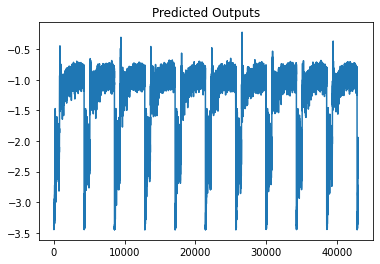

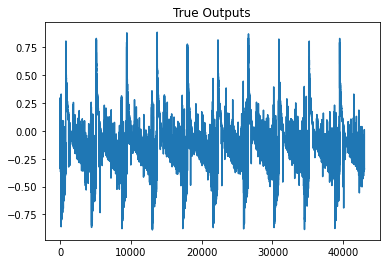

In [43]:
plt.cla
plt.figure(1)
plt.plot(predictOutputArray[1:43000])
plt.title('Predicted Outputs')
plt.figure(2)
plt.plot(testOutputsArray[1:43000])
plt.title('True Outputs')

In [44]:
inputsArray = inputsArray.reshape(len(inputsArray), 1, 22)
overfittingTestOutput = model.predict(inputsArray, verbose=1)

172015/172015 [==============================] - 272s 2ms/step


Text(0.5, 1.0, 'Overfitting Test True Outputs')

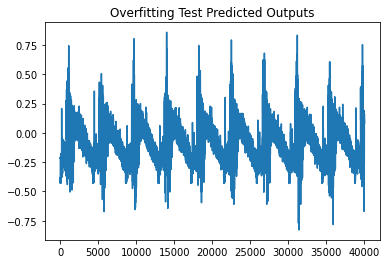

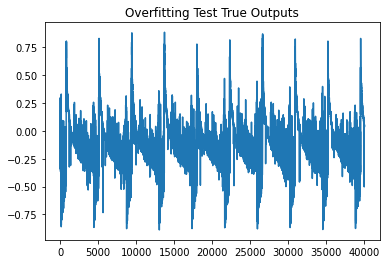

In [45]:
plt.figure(3)
plt.plot(overfittingTestOutput[1:40000])
plt.title('Overfitting Test Predicted Outputs')
plt.figure(4)
plt.plot(outputsArray[1:40000])
plt.title('Overfitting Test True Outputs')

In [ ]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y2 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y3 = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y4 = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.figure(5)
plt.plot(x, y)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)